### Week 2 - AR Models (Specification, Estimation, Model Properties, Forecasting) and Unit Root Tests

In [1]:
import numpy as np
import pandas as pd
from pandas import datetime
import matplotlib.pyplot as plt

from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import kpss

from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error

from math import sqrt

<ipython-input-1-7b5c90766e69>:3: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  from pandas import datetime


### 1. Autoregressive (AR) Models and Specification

An autoregressive (AR) model means our explanatory variables are lags of the dependent variable. Motivation? If we believe a variables past values can tell us what values it will have in the future.

i.e. $y_t = \phi_0 + \phi_1 y_{t-1} + u_t$.

The disturbance term $u_t$ in the AR(1) model is assumed to have zero mean, constant variance (homoskedascity) and zero autocovariance. Also called a white noise process.

If there is no 1st order autocorrelation i.e. $\phi_1 = 0$, then the model is effectively a white noise process, where all of the randomness comes from this term.

An AR(2) model is regressed by itself 1 period before and 2 periods before. Thus, an AR(p) model more generally speaking allows for p lags.

**Example: Unemployment Rate**. We will look at the data and then define its 1 period lag and show them side by side. Note that the first observation is missing because of the shift, which means when we do regressions, we have 1 less sample in our sample size i.e. $T - 1$

In [2]:
def parser(x):
    return datetime.strptime(x, '%Y-%m-%d')
series = pd.read_csv('../data/raw/macro.csv', parse_dates = [0], date_parser = parser)
pd.options.display.float_format = '{:.2f}'.format
unemployment = pd.DataFrame()
unemployment['Date'] = series['Date']
unemployment['URATE'] = series['URATE']
unemployment['URATE(-1)']= unemployment['URATE'].shift(1)
unemployment.head()

,Date,URATE,URATE(-1)
0,1969-07-01,1.70,NaN
1,1969-10-01,1.90,1.70
2,1970-01-01,1.60,1.90
3,1970-04-01,1.70,1.60
4,1970-07-01,1.70,1.70


In [3]:
unemployment.tail()

,Date,URATE,URATE(-1)
194,2018-01-01,5.52,5.46
195,2018-04-01,5.41,5.52
196,2018-07-01,5.19,5.41
197,2018-10-01,5.04,5.19
198,2019-01-01,5.02,5.04


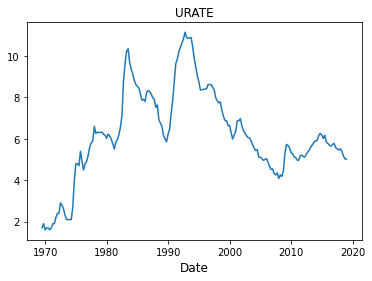

In [4]:
plt.plot(series['Date'], unemployment['URATE'])
graph = plt.xlabel('Date', fontsize=12)
graph = plt.title('URATE', fontsize=12)

### 2. White Noise Properties

The disturbance term u_t in the AR(1) model is assumed to have zero mean, constant variance (homoskedascity) and zero autocovariance. White noise properties formally written as:

$E(u_t) = 0$

$E(u^2_t) = \sigma^2_u$

$E(u_t u_{t-s}) = 0, s \ne 0$

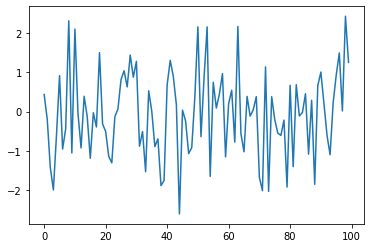

In [5]:
#White noise process
mean = 0
std = 1 
num_samples = 100
whitenoise = np.random.normal(mean, std, size=num_samples)
plt.plot(whitenoise)
plt.show()

Because the residuals are white noise, which have all autocvariances as zero, the ACF and PACF should not exhibit any significant autocorrelations and partial autocorrelations. We should check if our model residuals has white noise process.

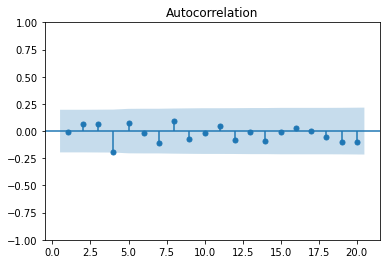

In [6]:
acfplot = plot_acf(whitenoise, alpha = .05, zero = False)

C:\Users\Max Ruan\AppData\Local\Programs\Python\Python38\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


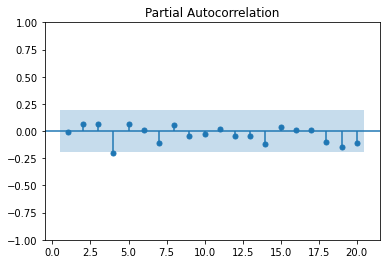

In [7]:
pacfplot = plot_pacf(whitenoise, alpha = .05, zero = False)

### Check Roots - Invertibility & Stationarity

There are rules to what parameters are to ensure stationarity. If we have a stationary series, the expectation/mean of y_t and y_t-1 should both be equal to mu i.e. the same. You thus, get mu = phi_0 (constant) + phi_1 * mu. Rearranging this gives us mu = (phi_0)/(1 - phi_1). Because mu must be finite, phi_1 cannot be equal to 1, as this indicates that the mean would approach infinity. 

To compute the unconditional variance, we start from mu = phi_0 + phi_1 * mu. We subtract this from y_t = phi_0 + phi_1 * y_t-1 + u_t. So we get y_t - mu = phi_1(y_t-1 - mu) + u_t. i.e. Deviations from the mean. We then square both sides to get: (y_t-1 - mu)^2 = phi_1^2(y_t-1 - mu)^2 + u_t^2 + 2*phi_1*(y_t-1 - mu)*u_t. Taking the unconditional expectation. The expression simplifies as u_t and y_t-1 - mu are independent. Thus we have E[(y_t - mu)^2] = phi_i^2*E[(y_t-1 - mu)^2] + E[u_t^2]. By definition E[u_t^2] the error variance is sigma_u^2. We expect that the unconditional variance is stationary so that E[(y_t - mu)^2] is the same as E[(y_t-1 - mu)^2], equal to say gamma_0. Thus, we get the expression: gamma_0 = phi_1^2*gamma_0 + sigma_u^2. Rearranging give us gamma_0 = sigma_u^2/(1 - phi_1^2). For it to be stationary, it must be finite, which is only the case if phi_1 is smaller than 1. 

It is important to be able to derive the unconditional mean, variance and covariances for AR(1) models and AR(2) models and AR(p) models.

### 3. Estimating AR(p) Model

We estimate the parameters of our models using **least squares (OLS)** estimator.

In [8]:
AR_lag = 1
variable = unemployment['URATE']

In [9]:
X = np.empty([np.count_nonzero(~np.isnan(variable)) - AR_lag,0])
for i in reversed(range(0,AR_lag + 1)):
    if i == AR_lag:
        Y = variable[pd.Series.first_valid_index(variable)+i:]
        Y = Y.values
    else:
        X1 = variable[pd.Series.first_valid_index(variable)+i:i-AR_lag]
        X = np.column_stack([X,X1])
X = sm.add_constant(X, prepend = True)
ARmodel = sm.OLS(Y, X).fit()
ARmodel.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.979
Model:                            OLS   Adj. R-squared:                  0.978
Method:                 Least Squares   F-statistic:                     8966.
Date:                Fri, 10 Jun 2022   Prob (F-statistic):          1.34e-165
Time:                        13:43:16   Log-Likelihood:                -52.307
No. Observations:                 198   AIC:                             108.6
Df Residuals:                     196   BIC:                             115.2
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.1467      0.068      2.151      0.033       0.012       0.281
x1             0.9791      0.010     94.687      0.000       0.959       1.000
==============================================================================
Omnibus:                       79.857   Durbin-Watson:                   0.984
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              282.895
Skew:                           1.626   Prob(JB):                     3.72e-62
Kurtosis:                       7.869   Cond. No.                         20.4
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Estimated AR(1) model is:
$URATE_t = 0.1467 + 0.9791 URATE_{t-1} + \hat u_t$

i.e. $\phi_0 = 0.1467, \phi_1 - 0.9791$

Note: Different AIC and BIC/SIC values are different to Eviews. 


The estimated AR(2) model:

$URATE_t = 0.1365 + 1.4869 URATE_{t-1} + -0.5075 URATE_{t-2} + \hat u_t$

$\hat u_t$ represents the OLS residuals i.e. $URATE_t - \hat {URATE_t}$

Also note that our original series has 199 observations but because we regress against its lags (198 observations), our regression is done with 198 observations. The greater the AR order, the more observations lost. 

We can check if the coefficients are statistically significant based on the p-value (< 0.05) or t-statistic (> 1.96).

In [10]:
print("Unconditional mean: " + str(ARmodel.params[0]/(1 - ARmodel.params[1])))
print("Unconditional variance: ")

Unconditional mean: 7.030207812617015
Unconditional variance: 


### 4. AR Model Properties - Unconditional Mean

From an AR model, we should know how to derive the inferred unconditional mean, variance and autocovariance. Understand the assumptions made and used.

e.g. Consider the AR(1) model:

$y_t = \phi_0 + \phi_1 y_{t-1} +u_t$

Unconditional mean:
1.   Obtain $E(y_t)$

$E(y_t) = \phi_0 + \phi_1 E(y_{t-1}) + E(u_t)$

2.   Use property that $E(u_t) = 0$

$E(y_t) = \phi_0 + \phi_1 E(y_{t-1})$

3. Stationary assumption implies $E(y_t) = E(y_{t-k} = \mu$)

$\mu = \phi_0 + \phi_1 \mu$

4. Solve for unconditional mean $\mu$

$\mu = \frac{\phi_0}{1-\phi_1}$

5. Note that stationary assumption implies $\phi_1 < 1$, because if $\phi_1 = 1$, mean would approach infinity (i.e. no longer finite). Note an unit root is where $\phi_1 = 1$.




### 5. Unconditional Variance for AR(1) Model

e.g. Consider the AR(1) model:

$y_t = \phi_0 + \phi_1 y_{t-1} +u_t$

1.   Obtain its 'mean' form (assuming stationarity and white noise errors)

$\mu = \phi_0 + \phi_1 \mu$

2. Obtain the deviations from the mean by subtracting the second equation:

$y_t - \mu = \phi_1 (y_{t-1} - \mu) +u_t$

3. Take the square of both sides:

$(y_t - \mu)^2 = \phi^2_1 (y_{t-1} - \mu)^2 +u^2_t + 2\phi_1(y_{t-1} - \mu)u_t$

4. Take the expectation, this gives the unconditional variance:

$E((y_t - \mu)^2) = \phi^2_1 E((y_{t-1} - \mu)^2) +E(u^2_t) + 2\phi_1E((y_{t-1} - \mu)u_t)$

5. We know that $(y_{t-1} - \mu)$ and $u_t$ are independent, which implies $E((y_{t-1} - \mu)u_t) = 0$

$E((y_t - \mu)^2) = \phi^2_1 E((y_{t-1} - \mu)^2) +E(u^2_t)$

6. By definition $E(u^2_t)$ is the error variance i.e. $E(u^2_t) = \sigma^2_u$

$E((y_t - \mu)^2) = \phi^2_1 E((y_{t-1} - \mu)^2) + \sigma^2_u$

7. Impose stationary in the variance condition:

$\gamma_0 = \phi^2_1 \gamma_0 + \sigma^2_u$

8. Solve for the unconditional variance:

$\gamma_0 = \frac{\sigma^2_u}{1-\phi^2_1}$

Note: the unconditional variance would not exist if $\phi_1 = 1$, otherwise the variance would be infinite. It also cannot be greater than 1 because variance by definition is non-negative.



### 6. Unconditional First Order Autocovariance (and $p$th Order Autocovariance) for AR(1) Model

e.g. Consider the AR(1) model:

$y_t = \phi_0 + \phi_1 y_{t-1} +u_t$

1. We define first order autocovariance as:

$\gamma_1 = E((y_t - \mu)(y_{t-1} - \mu))$

2. Obtain 'mean deviation' form (assuming stationarity and white noise errors):

$\mu = \phi_0 + \phi_1 \mu$

$y_t - \mu = \phi_1 (y_{t-1} - \mu) +u_t$

3. Don't take the square of both sides, now multiply both sides by $(y_{t-1} - \mu)$:

$(y_t - \mu)(y_{t-1}-\mu) = \phi_1 (y_{t-1} - \mu)^2 +u_t(y_{t-1}-\mu)$

4. Take the expectation, this gives the unconditional first order autocovariance:

$E((y_t - \mu)(y_{t-1}-\mu)) = \phi_1 E((y_{t-1} - \mu)^2) +E(u_t(y_{t-1}-\mu))$

5. We know that $(y_{t-1} - \mu)$ and $u_t$ are independent, which implies $E((y_{t-1} - \mu)u_t) = 0$

$E((y_t - \mu)(y_{t-1}-\mu)) = \phi_1 E((y_{t-1} - \mu)^2)$

6. By definition:

$\gamma_1 = \phi_1 \gamma_0)$

7. Input the unconditonal variance:

$\gamma_1 = \phi_1 \frac{\sigma^2_u}{1-\phi^2_1}$

For second order autocovariance:

$\gamma_2 = E((y_t - \mu)(y_{t-2} - \mu))$

We show that for the AR(1) model:

$\gamma_2 = \phi^2_1 \gamma_0$

For $p$th order autocovariance:

$\gamma_p = E((y_t - \mu)(y_{t-p} - \mu))$

$\gamma_p = \phi^p_1 \gamma_0$

### 7. First Order Autocorrelation and $p$th Order Autocorrelation for AR(1) Model

Autocorrelation is just standardised autocovariance, where we divide by the variance.

We know the variance of $y_t$ is $\gamma_0$.

Hence, first order autocorrelation (for AR(1) model) is:

$\rho_1 = \frac{\gamma_1}{\gamma_0} = \phi_1$

For $p$th order autocorrelation:
$\rho_p = \frac{\gamma_p}{\gamma_0} = \phi^p_1$

This tells us that the ACF decays exponentially if $|\phi_1|<1$, which is a condition imposed by stationarity.




### 8. Unconditional Mean, Variance, Autocovariance, Autocorrelation for AR(2) Model

More involved, not that simple.

Consider the AR(2) Model:

$y_t = \phi_0 + \phi_1 y_{t-1} + \phi_2 y_{t-2} + u_t$

Take expectation, impose zero error mean, impose mean stationarity (same at any time), gives us the mean:

$E(y_t) = \phi_0 + \phi_1 E(y_{t-1}) + \phi_2 E(y_{t-2})$

$\mu = \phi_0 + \phi_1 \mu + \phi_2 \mu$

$\mu = \frac{\phi_0}{1-\phi_1 - \phi_2}$

Note: unconditional mean doesn't exist if $\phi_1 + \phi_2 = 1$, otherwise mean would be infinite.

Subtract AR(2) model against its mean deviation form:

$y_t - \mu = \phi_1(y_{t-1} - \mu) + \phi_2 (y_{t-2} - \mu) + u_t$

Multiply both sides by $(y_t - \mu)$, take expectations and use definitions of autocovariances:

$(y_t - \mu)^2 = \phi_1(y_t - \mu)(y_{t-1} - \mu) + \phi_2 (y_t - \mu)(y_{t-2} - \mu) + (y_t - \mu)u_t$

$E((y_t - \mu)^2) = \phi_1E((y_t - \mu)(y_{t-1} - \mu)) + \phi_2 E((y_t - \mu)(y_{t-2} - \mu)) + E((y_t - \mu)u_t)$

$\gamma_0 = \phi_1 \gamma_1 + \phi_2 \gamma_2 + E((y_t - \mu)u_t)$

Dealing with the $E((y_t - \mu)u_t)$ term, we know that $y_t -\mu$ is:

$y_t - \mu = \phi_1(y_{t-1} - \mu) + \phi_2 (y_{t-2} - \mu) + u_t$

Multiply it by $u_t$ and then take the expectation:

$E(u_t(y_t - \mu)) = E(u_t(\phi_1(y_{t-1} - \mu) + \phi_2 (y_{t-2} - \mu) + u_t))$

$E(u_t(y_t - \mu)) = \phi_1 E(u_t(y_{t-1} - \mu)) + \phi_2 E(u_t(y_{t-2} - \mu)) + E(u^2_t)$

We know that the terms are independent and the definition of the error variance. this gives us the unconditional variance:

$E(u_t(y_t - \mu)) = \sigma^2_u$

$\gamma_0 = \phi_1 \gamma_1 + \phi_2 \gamma_2 + \sigma^2_u$

To get the first order autocovariance, we use the mean deviation form:

$y_t - \mu = \phi_1(y_{t-1} - \mu) + \phi_2 (y_{t-2} - \mu) + u_t$

Multiply both sides by $(y_{t-1} - \mu)$:

$(y_t - \mu)(y_{t-1} - \mu) = \phi_1(y_{t-1} - \mu)(y_{t-1} - \mu) + \phi_2 (y_{t-2} - \mu)(y_{t-1} - \mu) + u_t(y_{t-1} - \mu)$

Take unconditional expectation:

$E((y_t - \mu)(y_{t-1} - \mu)) = \phi_1 E((y_{t-1} - \mu)(y_{t-1} - \mu)) + \phi_2 E((y_{t-2} - \mu)(y_{t-1} - \mu)) + E(u_t(y_{t-1} - \mu))$

$\gamma_1 = \phi_1 \gamma_0 + \phi_2 \gamma_1$

$\gamma_1 = \frac{\phi_1}{1-\phi_2}\gamma_0$

To get the second order autocovariance, use mean deviation form, multiply by $(y_{t-2} - \mu)$ and take expectation:

$y_t - \mu = \phi_1(y_{t-1} - \mu) + \phi_2 (y_{t-2} - \mu) + u_t$

$(y_t - \mu)(y_{t-2} - \mu) = \phi_1(y_{t-1} - \mu)(y_{t-2} - \mu) + \phi_2 (y_{t-2} - \mu)(y_{t-2} - \mu) + u_t(y_{t-2} - \mu)$

$\gamma_2 = \phi_1 \gamma_1 + \phi_2 \gamma_0$

Substitute in the $\gamma_1$ equation:

$\gamma_2 = \frac{\phi^2_1}{1-\phi_2}\gamma_0 + \phi_2 \gamma_0 = (\frac{\phi^2_1}{1-\phi_2} + \phi_2)\gamma_0$

We can finally solve for variance because we now have the two autocovariance terms in terms of coefficients and variance terms:

$\gamma_0 = \phi_1 \gamma_1 + \phi_2 \gamma_2 + \sigma^2_u$

$\gamma_0 = \frac{\phi^2_1}{1-\phi_2}\gamma_0 +  (\frac{\phi_2 \phi^2_1}{1-\phi_2} + \phi^2_2)\gamma_0 + \sigma^2_u$

$\gamma_0 = \frac{(1-\phi_2)\sigma^2_u}{(1+\phi_2)((1-\phi_2)^2 - \phi^2_1)}$


### 9. Ex-Ante Point Forecasting 

We have the OLS estimates for our model parameters. Now to forecast $y_{t+1}$, our model is thus $\phi_0 + \phi_1 y_t + u_{t+1}$. 

We have today's value $y_t$, we don't know the parameters. 

But we can replace the unknown parameters using our OLS estimates $\hat \phi_0$ and $\hat \phi_1$. 

The futue value of the error term is replaced with its unconditional mean, which is 0. 

Thus our forecast at $t+1$ is thus $\hat y_{t+1} = \hat \phi_0 + \hat \phi_1 y_t$.

In [11]:
num_forecasts = 7
starting_values = Y[-AR_lag:]
for i in range(0, num_forecasts):
    forecast_1period = ARmodel.params[0]
    for i in range(0, AR_lag):
        forecast_1period = forecast_1period + ARmodel.params[i+1]*starting_values[-1-i]
    starting_values = np.append(starting_values,forecast_1period)
print(starting_values)

[5.0186967  5.06067821 5.10178354 5.14203097 5.18143842 5.2200234
 5.25780309 5.2947943 ]


The unemployment rate is predicted to increase continually over the forecast period, peaking at 5.29% in 2020Q4.

The property of our model is that forecasts will converge to the long-run mean given stationarity. Above we have computed that the long-run mean is 7.02ish i.e. Natural rate of unemployment is 7.02%, which our forecasts will approach.

The long-run estimated AR(1) mean is:
$\frac{0.1467}{1-0.9791} = 7.0191$

### 10. Ex-Ante Interval Forecasting 

We can also think about interval forecasts i.e. a range of future values in order to reflect uncertainties. There are 2 types of uncertainties in our forecasting model: 
1.   Parameter uncertainty (OLS estimate $\hat \beta$ vs. the population parameter $\beta$) 
2.   Disturbance/Error uncertainty (as $\sigma^2_u > 0$).

### 11. Ex-Post Forecasting 

Ex-Ante Forecasting is where all of the information is used to estimate the model up to the most recent observation. 

Ex-Post forecasting is an alternative method where you use a restricted sample and generate forecasts over a horizon, the benefit where you can compare your results/performance with the actual data.

In [12]:
output = pd.DataFrame()
output['AR(1) Fitted Y'] = ARmodel.fittedvalues
output['Actual'] = (variable[pd.Series.first_valid_index(variable)+1:]).values
output['Residual'] = output['Actual'] - output['AR(1) Fitted Y']
output.head()

,AR(1) Fitted Y,Actual,Residual
0,1.81,1.90,0.09
1,2.01,1.60,-0.41
2,1.71,1.70,-0.01
3,1.81,1.70,-0.11
4,1.81,1.60,-0.21


In [13]:
expected = output['Actual']
predictions = output['AR(1) Fitted Y']
#Mean Absolute Error
mae = mean_absolute_error(expected, predictions)
#Mean Square Error
mse = mean_squared_error(expected, predictions)
#Root Mean Squared Error
rmse = sqrt(mse)
print('Mean Absolute Error: %f' % mae)
print('Mean Square Error: %f' % mse)
print('Root Mean Square Error: %f' % rmse)

Mean Absolute Error: 0.221709
Mean Square Error: 0.099308
Root Mean Square Error: 0.315132


### Check Residuals Are White Noise

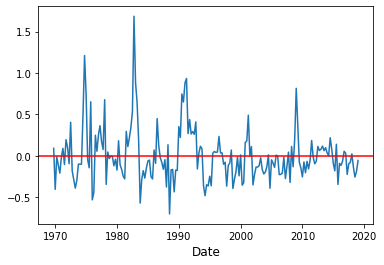

In [14]:
plt.plot(series['Date'][AR_lag:], output['Residual'])
plt.axhline(y = output['Residual'].mean(), color = 'r', linestyle = '-')
graph = plt.xlabel('Date', fontsize=12)

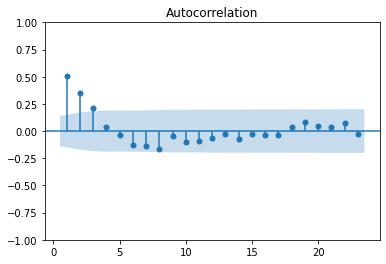

In [15]:
acfplot = plot_acf(output['Residual'], alpha = .05, zero = False)

### Nonlinear Time Series Extensions

AR Models are linear.

We can have non-linear models e.g. nonlinear AR(1) models:

$y_t = \phi_0 + \phi_1 y_{t-1} + \beta y^2_{t-1} + u_t$

Another nonlinear AR(1) ANN model is:
$y_t = \phi_0 + \phi_1 y_{t-1} + \beta \frac{1}{1 + \exp(-(\delta_0+\delta_1y_{t-1}))} + u_t$

This is known as a hidden-layer, feed-forward artificial neural network where the non-linear term is called a 'squasher' with a hidden layer and a neurode.

Estimation of such models involves computing the residual sum of squares for each parameter estimates, known as the 'fitness function'. This is done iteratively and used to update the parameter estimates to reduces sum of squares - this process is known as ML. Estimation of ANN models are numerically difficult.

Other nonlinear models include:

1.   Self-exciting threshold autoregressive models (SETAR)
2.   Smooth Transitional Autoregressive models (STAR)
3.   Genetic algorithms
4.   Chaos theory - produces 'random' looking behaviour which is actually deterministic (which implies predictability) - does that mean stock price movmeents that appear random could reflect a nonlinear deterministic process? If so, the difficulty is finding the parameters!
5.   Artifical neural networks (ANN) and machine learning (ML)



### Augmented Dickey Fuller (ADF) / Unit Root Test

Null: Time series can be represented by a unit root i.e. not-stationary, 
Alternative: Time series cannot be rejected by a unit root, 
P-value below 0.05 suggests we reject the null at the 5% level. This tests for stochastic non-stationarity. This is computed as the change in the variable regressed against a constant, and it lagged values and lagged changes.

In [16]:
X = variable.values[pd.Series.first_valid_index(variable):]
result = adfuller(X)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Lags Used: %f' % result[2])
print('Observations Used %f' % result[3])
print('Critical Values:')
for key, value in result[4].items():
	print('\t%s: %.3f' % (key, value))
if (result[1]<0.05):
    print("Reject null at 5% level? YES")
else:
    print("Reject null at 5% level? NO")

ADF Statistic: -2.732264
p-value: 0.068620
Lags Used: 2.000000
Observations Used 196.000000
Critical Values:
	1%: -3.464
	5%: -2.876
	10%: -2.575
Reject null at 5% level? NO


### Kwiatkowski-Phillips-Schmidt-Shin (KPSS) Test

Null: time series is stationarity around a deterministic trend against the alternative of a unit root. Option: c = stationarity around a constant, ct = stationarity around a trend. P-value below 0.05 suggests we reject the null at the 5% level.

In [17]:
kpssresults = kpss(variable[pd.Series.first_valid_index(variable):],'c')

In [18]:
kpss_pvalue = kpssresults[1]
print("P-value 5% level: {:.4f}".format(kpss_pvalue))

P-value 5% level: 0.0769


### Unanswered Questions

1.   What is the difference in the intuition and usage of PACF and ACF?
2.   Why is stationarity important?
3.   Stationary series should have rapidly decaying ACFs. What is considered rapidly decaying?
4.   What is the main purpose of the ACF and PACF? Is it any good at detecting stationarity? Is it mainly to identify what AR, MA or ARMA model is appropriate model to use to predict our variable of interest? Are there any other purposes?
5.   Python packages for AR seem to compute using maximum likelihood. Would there be any practical problems with using this method?
6.   We know that $(y_{t-1} - \mu)$ and $u_t$ are independent?

